# Kappa Explorations

# Basics

## Imports

In [702]:
import pandas as pd
from statsmodels import stats 
import matplotlib.pyplot as plt
import copy
import numpy as np
import math
from sklearn.neighbors import KernelDensity

import psycopg2
import sqlalchemy
from sqlalchemy import create_engine




### Constants


In [703]:
conn_url = sqlalchemy.engine.URL.create(
    drivername='postgresql+psycopg2',
    username='jericho',
    password='Ilikesony1!',
    host='holocron.local',
    database='postgres'
)

eng = create_engine(conn_url)

n_bins = 6


#colors = ['maroon','indigo','navy','darkgreen']
#colors = ['royalblue','olivedrab','brown','rebeccapurple','darkgoldenrod']
#colors = ['#003f5c','#444e86','#955196','#dd5182','#ff6e54','#ffa600']
colors = ['blue', 'green', 'purple', 'red']


codes = {
'01_agg_H': 'Personal Care', 
'02_agg_H': 'Household Activities', 
'03_agg_H': 'Care for HH Members', 
'04_agg_H': 'Care for NH Members', 
'05_agg_H': 'Work', 
'06_agg_H': 'Education', 
'07_agg_H': 'Consumer Purchases', 
'08_agg_H': 'Prof. & Pers. Services',
'09_agg_H': 'Household Services', 
'10_agg_H': 'Govt Services & Civic', 
'11_agg_H': 'Eating & Drinking', 
'12_agg_H': 'Socializing & Leisure', 
'13_agg_H': 'Sports, Exrc & Rec', 
'14_agg_H': 'Religious & Spiritual', 
'15_agg_H': 'Volunteer Activities', 
'16_agg_H': 'Phone calls', 
'18_agg_H': 'Traveling', 
'ALL_TU_H': 'All Activities', 
'CARE_TU_H': 'Care-Related Activities', 
'SOCIAL_TU_H': 'Social Activities'
}

## Functions

### Binplot

In [ ]:
def binplot_dim(ax, x, y, nbins, **kwargs):
    df_xy = pd.DataFrame({'x':x,'y':y})
    df_xy = df_xy.sort_values('x')
    df_xy['xbin'] = pd.cut(df_xy['x'], nbins,)

    df_mean = df_xy.groupby('xbin').mean().reset_index()
    df_mean = df_mean[['xbin','y']]
    df_mean.columns = ['xbin','ybar']  

    df_xy = df_xy.merge(df_mean, how='left', on='xbin')
    df_xy['ysqerr'] = (df_xy['y']-df_xy['ybar'])**2
    df_xy['count'] = 1
    df_xy = df_xy.groupby('xbin').sum()
    df_xy = df_xy.reset_index()

    xbin = [[i.left, i.right] for i in df_xy['xbin'].tolist()]
    df_xy['xbin'] = xbin
    df_xy['x'] = [sum(i)/2 for i in xbin]
    df_xy['ystdev'] = (df_xy['ysqerr']/df_xy['count'])**0.5
    df_xy['ybar'] = df_xy['y']/df_xy['count']
    df_xy['ci_95'] = 1.96*(df_xy['ystdev'] / df_xy['count']**0.5)

    for i in xbin:
        ax.axvline(i[0], linestyle='--', c='grey', alpha=0.5)
    ax.axvline(xbin[-1][1], linestyle='--', c='grey', alpha=0.5)

    if 'linestyle' in kwargs.keys():
        style = kwargs['linestyle']
    else:
        style = '-'

    if 'alpha' in kwargs.keys():
        a = kwargs['alpha']
    else:
        a = 1

    ax.plot(df_xy['x'], df_xy['ybar'],c=kwargs['c'], linestyle=style, linewidth = int(kwargs['l']), marker=kwargs['m'], markersize=kwargs['lms'], label=kwargs['label'], alpha=a)
    #ax.scatter(df_xy['x'], df_xy['ybar'],c=kwargs['c'], s = kwargs['s']*1.5, marker = kwargs['m'])
    
    x_mid = df_xy['x'].tolist()
    ybar = df_xy['ybar'].tolist()
    ci95 = df_xy['ci_95'].tolist()
    
    for i in range(len(x_mid)):
        xt = x_mid[i]
        ymin = ybar[i]-ci95[i]
        ymax = ybar[i]+ci95[i]
        ax.vlines(x_mid[i], ymin=ymin, ymax=ymax, colors=kwargs['c'], linewidth = int(kwargs['l']), alpha=a)
        ax.scatter([xt,xt],[ymin,ymax], marker='_', c=kwargs['c'], s=kwargs['s'], alpha=a)
    return ax

### Boxplot

In [ ]:
def boxplot_stats(x):
    x = [i for i in x if not (np.isnan(i))]
    x_sort = sorted(x)
    x_25 = x_sort[int(len(x)/4)]
    x_75 = x_sort[int((len(x)/4)*3)]
    iqr_rang = (x_75-x_25)*1.5
    x_outliers = [i for i in x if i<(x_25-iqr_rang) or i>(x_75+iqr_rang)]
    return [max(min(x), x_25-iqr_rang), 
                x_25, 
                sum(x)/len(x), 
                x_75, 
                min(max(x), x_75+iqr_rang), 
                x_outliers]

### $c$ classifier helpers

In [ ]:
def race_classifier(x):
    if x == 'Black~H':
        return 'Black'
    elif x == 'Other':
        return 'White&Other'
    elif x == 'White~H':
        return 'White&Other'
    else: return x



def edu_classifer(x):
    if x == 'lt_highschool':
        return 'LT_HS'
    elif x in ['some_college', 'highschool', 'post_college_degree', 'trade_school_hs', 'college_degree']:
        return 'HS+'
    else:
        return x

### KDE helpers

In [685]:
def kde_2d(x_dim, y_dim, bwidth=0.14):
    xymatrix = np.column_stack((x_dim, y_dim))
    kde = KernelDensity(bandwidth=bwidth).fit(xymatrix)
    x_range = [((min(x_dim)*10)//1)/10, (((max(x_dim)*10)//1)+1)/10]
    y_range = [((min(y_dim)*10)//1)/10, (((max(y_dim)*10)//1)+1)/10]
    x_lin = np.linspace(x_range[0], x_range[1], num=300)
    y_lin = np.linspace(y_range[0], y_range[1], num=300)
    X, Y = np.meshgrid(x_lin,y_lin)
    XX = np.ravel(X)
    YY = np.ravel(Y)
    XY = np.column_stack((XX,YY))

    ZZ = kde.score_samples(XY)
    Z = ZZ.reshape(X.shape)
    return X, Y, Z



def normalize_whole_plot(Z):
    Z_out = (Z-Z.min()) / (Z.max()-Z.min())
    return Z_out



def normalize_cols(Z):
    Z_df = pd.DataFrame(Z)
    for col in Z_df.columns:
        max_val = Z_df[col].max()
        min_val = Z_df[col].min()
        Z_df[col] = (Z_df[col]-min_val) / (max_val-min_val)
    return Z_df

## Data Import & Cleaning

In [687]:
f = './data/social_trends_dataset.csv'
df = pd.read_csv(f)
df['weighted_f'] = df['Family Available'] * df['weight']

df_resp_weight = pd.read_csv('./data/atus_resp_who_agg.csv')
df_resp_weight = df_resp_weight[['TUCASEID','NEW_WEIGHT']]

df_cbsa = pd.read_csv('./data/atus_resp_who_agg.csv')
df_cbsa = df_cbsa[['GTCBSA','POP', 'LOG_POP', 'NEW_WEIGHT']]
df_weights = df_cbsa[['GTCBSA','NEW_WEIGHT']].groupby('GTCBSA').sum()
df_cbsa = df_cbsa[['GTCBSA','POP','LOG_POP']].drop_duplicates()
df_cbsa = df_cbsa.merge(df_weights, how='left', on='GTCBSA')

df_resp_activity = pd.read_csv('./data/atus_resp_activity.csv')

df_fg = pd.read_csv('./data/f(g)_all_a_wd_we.csv')

phi = df['Family Available'].sum() / len(df)

atus_df = pd.read_csv('./data/atus_responses_2016-2019.csv')
atus_df = atus_df[['TUCASEID', 'TEAGE', 'TESEX', 'HEFAMINC', 'PTDTRACE', 'PEHSPNON', 'PEEDUCA', 'GTCBSA']]
atus_df.columns = ['TUCASEID', 'Age', 'Sex', 'Fam_Inc', 'Race', 'Hisp', 'Educ', 'GTCBSA']
atus_df = atus_df[atus_df['GTCBSA']>0]

In [688]:
race = {#1: 'White', 
        2: 'Black', 
        #3: 'AmericanIndian', 
        #4: 'Asian', 
        #5: 'PacificIslander/Hawaiian'
        }

ethn = {1: 'Hispanic', 
        2: 'NonHispanic'}

sex  = {1: 'Male',
        2: 'Female'}

educ = {39: 'HighSchoolGraduate'}

atus_encoded_df = copy.deepcopy(atus_df)
atus_encoded_df['SexClass'] = atus_encoded_df['Sex'].apply(lambda x: sex[x])
atus_encoded_df.head()

atus_encoded_df['Race_Encoded'] = [race[i] if i in race.keys() else 'White&Other' for i in atus_encoded_df['Race'].tolist()]
atus_encoded_df['Ethn_Encoded'] = [ethn[i] if i in ethn.keys() else 'White&Other' for i in atus_encoded_df['Hisp'].tolist()]
r = atus_encoded_df['Race_Encoded'].tolist()
e = atus_encoded_df['Ethn_Encoded'].tolist()
re = [r[i] if e[i] == 'NonHispanic' else 'Hispanic' for i in range(len(r))]
atus_encoded_df['RaceEthn' ] = re

def age_class(x):
    if x < 23:
        return 'Age<23'
    elif x < 60:
        return '23<=Age<60'
    elif x >= 60:
        return 'Age>=60'
    else: return x

atus_encoded_df['AgeClass'] = atus_encoded_df['Age'].apply(age_class)

def education_class(x):
    if x > 38:
        return 'HS+'
    else:
        return 'LT_HS'

atus_encoded_df['EduClass'] = atus_encoded_df['Educ'].apply(education_class)

atus_encoded_df = copy.copy(atus_encoded_df[['TUCASEID', 'GTCBSA','SexClass', 'RaceEthn', 'AgeClass', 'EduClass']])
atus_raw_counts = atus_encoded_df[['TUCASEID','GTCBSA']].groupby('GTCBSA').count()
for col in ['SexClass', 'RaceEthn', 'AgeClass', 'EduClass']:
    for val in atus_encoded_df[col].unique():
        tdf = atus_encoded_df[atus_encoded_df[col]==val]
        tdf = tdf[[col,'GTCBSA']].groupby('GTCBSA').count()
        tdf.columns = [col+'_'+val]
        atus_raw_counts = atus_raw_counts.join(tdf)  

atus_raw_counts.head()

df_u_gca = atus_encoded_df.merge(df_resp_activity, how='left', on='TUCASEID')

df_u_gca

TUCASEID  GTCBSA SexClass     RaceEthn    AgeClass EduClass  \
0      20160101160045   12060   Female  White&Other     Age>=60      HS+   
1      20160101160069   47900   Female        Black  23<=Age<60      HS+   
2      20160101160094   33100   Female     Hispanic      Age<23    LT_HS   
3      20160101160116   35620   Female  White&Other  23<=Age<60      HS+   
4      20160101160139   17140     Male  White&Other     Age>=60      HS+   
...               ...     ...      ...          ...         ...      ...   
31790  20191212192170   49340   Female  White&Other  23<=Age<60      HS+   
31791  20191212192214   47260   Female  White&Other  23<=Age<60      HS+   
31792  20191212192229   16700   Female  White&Other     Age>=60      HS+   
31793  20191212192265   42660   Female  White&Other  23<=Age<60      HS+   
31794  20191212192270   37980   Female  White&Other  23<=Age<60      HS+   

       1_agg_H  10_agg_H  11_agg_H  12_agg_H  ...  7_agg_H  8_agg_H  9_agg_H  \
0          0.0       0.0       0.0       1.0  ...      0.0      0.0      0.0   
1          0.0       0.0       0.0       0.0  ...      0.0      0.0      0.0   
2          0.0       0.0       0.0       0.0  ...      0.0      0.0      0.0   
3          0.0       0.0       0.0       0.0  ...      0.0      0.0      0.0   
4          0.0       0.0       0.0       0.0  ...      0.0      0.0      0.0   
...        ...       ...       ...       ...  ...      ...      ...      ...   
31790      0.0       0.0       1.0       1.0  ...      0.0      0.0      0.0   
31791      0.0       0.0       0.0       0.0  ...      0.0      0.0      0.0   
31792      0.0       0.0       1.0       1.0  ...      0.0      0.0      0.0   
31793      0.0       0.0       0.0       0.0  ...      0.0      0.0      0.0   
31794      0.0       0.0       0.0       1.0  ...      0.0      0.0      0.0   

       ALL_TU_H  SOCIAL_TU_H  CARE_TU_H  LONGEST_TRIP_DUR  \
0           1.0          1.0        0.0              15.0   
1           0.0          0.0        0.0              30.0   
2           0.0          0.0        0.0              10.0   
3           0.0          0.0        0.0              20.0   
4           0.0          0.0        0.0               5.0   
...         ...          ...        ...               ...   
31790       1.0          1.0        0.0              30.0   
31791       0.0          0.0        0.0               5.0   
31792       1.0          1.0        0.0               NaN   
31793       0.0          0.0        0.0              60.0   
31794       1.0          1.0        0.0              30.0   

       LONGEST_TRIP_TIER2CODE  Division  TUDIARYDAY  
0                        12.0       5.0         6.0  
1                         7.0       5.0         1.0  
2                        13.0       5.0         1.0  
3                         3.0       2.0         3.0  
4                        13.0       3.0         1.0  
...                       ...       ...         ...  
31790                     5.0       1.0         2.0  
31791                     7.0       5.0         1.0  
31792                     NaN       5.0         7.0  
31793                     5.0       9.0         5.0  
31794                    12.0       2.0         4.0  

[31795 rows x 30 columns]

In [690]:
df_pew = copy.deepcopy(df)
df_pew = df_pew[df_pew.columns.tolist()[1:]]

df_pew['AgeClass'] = df_pew['age'].replace('97 or older', 97).astype(float).apply(age_class)
df_pew['SexClass'] = df_pew['sex']
df_pew['RaceEthn'] = df_pew['racethn'].apply(race_classifier)
df_pew['EduClass'] = df_pew['Education'].apply(edu_classifer)

df_pew.head()

msa        state   FIPS   GTCBSA     sex q7_family_members  NO family  \
0  14860  Connecticut   9001  14860.0  Female              None          1   
1  13820      Alabama   1115  13820.0  Female         1 up to 5          0   
2  13820      Alabama   1021  13820.0  Female      More than 20          0   
3  13820      Alabama   1073  13820.0  Female        6 up to 10          0   
4  42660   Washington  53033  42660.0  Female              None          1   

   Family Available age            Education income_short recage  racethn  \
0                 0  44         some_college       10-20k  35-44  White~H   
1                 1  49           highschool       10-20k  45-54  Black~H   
2                 1  74        lt_highschool       10-20k    65+  White~H   
3                 1  80           highschool       10-20k    65+  White~H   
4                 0  26  post_college_degree       10-20k  25-34  White~H   

     weight  weighted_f    AgeClass SexClass     RaceEthn EduClass  
0  3.547619    0.000000  23<=Age<60   Female  White&Other      HS+  
1  2.250000    2.250000  23<=Age<60   Female        Black      HS+  
2  2.523810    2.523810     Age>=60   Female  White&Other    LT_HS  
3  3.333333    3.333333     Age>=60   Female  White&Other      HS+  
4  5.119048    0.000000  23<=Age<60   Female  White&Other      HS+

In [691]:
classes = {}

for col in df_pew.columns.tolist()[-4:]:
    classes[col] = df_pew[col].unique().tolist()

np.isnan(classes['EduClass'][2])

c1_type_array = []
c1_array = []
c2_type_array = []
c2_array = []
phi_array = []

class1 = 'SexClass'
for class2 in classes.keys():
    if class2 != class1:
        for c1 in classes[class1]:
            for c2 in classes[class2]:
                if type(c2)==type(0.0):
                    pass
                else:
                    #print(class1, class2, c1, c2, type(c2))
                    tdf = df_pew[df_pew[class1]==c1]
                    tdf = tdf[tdf[class2]==c2]
                    _phi = tdf['Family Available'].sum() / len(tdf)
                    c1_array.append(c1)
                    c2_array.append(c2)
                    c1_type_array.append(class1)
                    c2_type_array.append(class2)
                    phi_array.append(_phi)

phi_c_df = pd.DataFrame({'class1_type':c1_type_array, 'class1': c1_array, 'class2_type':c2_type_array, 'class2': c2_array, 'phi_c':phi_array})
phi_c_df


class1_type  class1 class2_type       class2     phi_c
0     SexClass  Female    AgeClass   23<=Age<60  0.794379
1     SexClass  Female    AgeClass      Age>=60  0.811475
2     SexClass  Female    AgeClass       Age<23  0.833333
3     SexClass    Male    AgeClass   23<=Age<60  0.826215
4     SexClass    Male    AgeClass      Age>=60  0.834532
5     SexClass    Male    AgeClass       Age<23  0.838710
6     SexClass  Female    RaceEthn  White&Other  0.804878
7     SexClass  Female    RaceEthn        Black  0.827586
8     SexClass  Female    RaceEthn     Hispanic  0.743590
9     SexClass    Male    RaceEthn  White&Other  0.825322
10    SexClass    Male    RaceEthn        Black  0.863158
11    SexClass    Male    RaceEthn     Hispanic  0.820513
12    SexClass  Female    EduClass          HS+  0.802434
13    SexClass  Female    EduClass        LT_HS  0.801980
14    SexClass    Male    EduClass          HS+  0.826788
15    SexClass    Male    EduClass        LT_HS  0.852273

In [692]:
alphas = ['1_agg_H', '2_agg_H', '3_agg_H', '4_agg_H', '5_agg_H', '6_agg_H', '7_agg_H', 
    '8_agg_H', '9_agg_H', '10_agg_H', '11_agg_H', '12_agg_H', '13_agg_H', '14_agg_H', 
    '15_agg_H', '16_agg_H', '18_agg_H', 'ALL_TU_H', 'SOCIAL_TU_H', 'CARE_TU_H']

# Analysis

In [693]:
def get_pew_tus_data(threshold):
    pew_threshold = threshold # will give results > this number

    df_u_gca_weight = df_resp_weight.merge(df_u_gca, on='TUCASEID', how='left')
    df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(df_pew['GTCBSA'].tolist())].copy()
    pew_thr_df = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())].copy()
    pew_thr_df = pew_thr_df[['GTCBSA']]
    pew_thr_df['count'] = 1
    pew_thr_df = pew_thr_df.groupby('GTCBSA').sum()
    pew_thr_df = pew_thr_df.reset_index()
    pew_thr_df = pew_thr_df[pew_thr_df['count'] > pew_threshold]
    df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(pew_thr_df['GTCBSA'].tolist())].copy()
    df_pew_trunc = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())].copy()

    

    return df_pew_trunc, df_tus_trunc

df_pew_trunc, df_tus_trunc = get_pew_tus_data(0)

In [722]:
# temp_export = df_cbsa.merge(df_u_gca_weight, how='right', on='GTCBSA')
# temp_export

df_pew

df_pew_trunc_p_bins = copy.deepcopy(df_pew)
df_pew_trunc_p_bins = df_pew_trunc_p_bins[~df_pew_trunc_p_bins['q7_family_members'].isna()]
df_pew_trunc_p_bins['phi_w_min_raw']  = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_min[x])
df_pew_trunc_p_bins['phi_w_max_raw']  = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_max[x])
df_pew_trunc_p_bins['phi_w_mean_raw'] = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_mean[x])
df_pew_trunc_p_bins = cbsa_bins.merge(df_pew_trunc_p_bins, on='GTCBSA', how='right')



df_pew_trunc_p_bins['phi_w_mean'] = (df_pew_trunc_p_bins['phi_w_mean_raw']-df_pew_trunc_p_bins['phi_w_mean_raw'].min()) / (df_pew_trunc_p_bins['phi_w_mean_raw'].max() - df_pew_trunc_p_bins['phi_w_mean_raw'].min())
df_pew_trunc_p_bins['phi_w_min']  = (df_pew_trunc_p_bins['phi_w_min_raw'] -df_pew_trunc_p_bins['phi_w_min_raw'].min())  / (df_pew_trunc_p_bins['phi_w_min_raw'].max()  - df_pew_trunc_p_bins['phi_w_min_raw'].min())
df_pew_trunc_p_bins['phi_w_max']  = (df_pew_trunc_p_bins['phi_w_max_raw'] -df_pew_trunc_p_bins['phi_w_max_raw'].min())  / (df_pew_trunc_p_bins['phi_w_max_raw'].max()  - df_pew_trunc_p_bins['phi_w_max_raw'].min())
df_pew_trunc_p_bins

df_pew_trunc_p_bins['pop_bin_min'] = df_pew_trunc_p_bins['pop_bin'].apply(lambda x: x.left)
df_pew_trunc_p_bins['pop_bin_max'] = df_pew_trunc_p_bins['pop_bin'].apply(lambda x: x.right)

df_pew_trunc_p_bins = df_pew_trunc_p_bins.drop('pop_bin', axis=1)
df_pew_trunc_p_bins

GTCBSA    msa          state   FIPS     sex q7_family_members  \
0     14860.0  14860    Connecticut   9001  Female              None   
1     13820.0  13820        Alabama   1115  Female         1 up to 5   
2     13820.0  13820        Alabama   1021  Female      More than 20   
3     13820.0  13820        Alabama   1073  Female        6 up to 10   
4     42660.0  42660     Washington  53033  Female              None   
...       ...    ...            ...    ...     ...               ...   
2244  35620.0  35620     New Jersey  34027  Female         1 up to 5   
2245  35620.0  35620     New Jersey  34027    Male       11 up to 20   
2246  35620.0  35620     New Jersey  34013    Male              None   
2247  14460.0  14460  Massachusetts  25009    Male         1 up to 5   
2248  29620.0  29620       Michigan  26037    Male       11 up to 20   

      NO family  Family Available age            Education  ...     RaceEthn  \
0             1                 0  44         some_college  ...  White&Other   
1             0                 1  49           highschool  ...        Black   
2             0                 1  74        lt_highschool  ...  White&Other   
3             0                 1  80           highschool  ...  White&Other   
4             1                 0  26  post_college_degree  ...  White&Other   
...         ...               ...  ..                  ...  ...          ...   
2244          0                 1  70  post_college_degree  ...  White&Other   
2245          0                 1  28  post_college_degree  ...  White&Other   
2246          1                 0  60           highschool  ...  White&Other   
2247          0                 1  76           highschool  ...  White&Other   
2248          0                 1  59           highschool  ...  White&Other   

     EduClass phi_w_min_raw  phi_w_max_raw  phi_w_mean_raw phi_w_mean  \
0         HS+      0.000000       0.000000            0.00       0.00   
1         HS+      0.047619       0.166667            0.12       0.12   
2       LT_HS      1.000000       1.000000            1.00       1.00   
3         HS+      0.285714       0.333333            0.32       0.32   
4         HS+      0.000000       0.000000            0.00       0.00   
...       ...           ...            ...             ...        ...   
2244      HS+      0.047619       0.166667            0.12       0.12   
2245      HS+      0.523810       0.666667            0.64       0.64   
2246      HS+      0.000000       0.000000            0.00       0.00   
2247      HS+      0.047619       0.166667            0.12       0.12   
2248      HS+      0.523810       0.666667            0.64       0.64   

     phi_w_min phi_w_max pop_bin_min  pop_bin_max  
0     0.000000  0.000000       5.737        6.125  
1     0.047619  0.166667       5.737        6.125  
2     1.000000  1.000000       5.737        6.125  
3     0.285714  0.333333       5.737        6.125  
4     0.000000  0.000000       6.513        6.902  
...        ...       ...         ...          ...  
2244  0.047619  0.166667       6.902        7.290  
2245  0.523810  0.666667       6.902        7.290  
2246  0.000000  0.000000       6.902        7.290  
2247  0.047619  0.166667       6.513        6.902  
2248  0.523810  0.666667       5.737        6.125  

[2249 rows x 27 columns]

In [721]:
df_pew_trunc_p_bins.to_sql('mkl1_PEW_phi_w', con=eng, schema='cdsdata')

249

In [701]:
df_u_gca_weight 

TUCASEID  NEW_WEIGHT  GTCBSA SexClass     RaceEthn    AgeClass  \
0      20160101160045     20976.0   12060   Female  White&Other     Age>=60   
1      20160101160069     18319.0   47900   Female        Black  23<=Age<60   
2      20160101160094     57019.0   33100   Female     Hispanic      Age<23   
3      20160101160116     33681.0   35620   Female  White&Other  23<=Age<60   
4      20160101160139     18784.0   17140     Male  White&Other     Age>=60   
...               ...         ...     ...      ...          ...         ...   
31658  20191212192170     13707.0   49340   Female  White&Other  23<=Age<60   
31659  20191212192214     34842.0   47260   Female  White&Other  23<=Age<60   
31660  20191212192229     17294.0   16700   Female  White&Other     Age>=60   
31661  20191212192265     18999.0   42660   Female  White&Other  23<=Age<60   
31662  20191212192270     29451.0   37980   Female  White&Other  23<=Age<60   

      EduClass  1_agg_H  10_agg_H  11_agg_H  ...  7_agg_H  8_agg_H  9_agg_H  \
0          HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   
1          HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   
2        LT_HS      0.0       0.0       0.0  ...      0.0      0.0      0.0   
3          HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   
4          HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   
...        ...      ...       ...       ...  ...      ...      ...      ...   
31658      HS+      0.0       0.0       1.0  ...      0.0      0.0      0.0   
31659      HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   
31660      HS+      0.0       0.0       1.0  ...      0.0      0.0      0.0   
31661      HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   
31662      HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   

       ALL_TU_H  SOCIAL_TU_H  CARE_TU_H  LONGEST_TRIP_DUR  \
0           1.0          1.0        0.0              15.0   
1           0.0          0.0        0.0              30.0   
2           0.0          0.0        0.0              10.0   
3           0.0          0.0        0.0              20.0   
4           0.0          0.0        0.0               5.0   
...         ...          ...        ...               ...   
31658       1.0          1.0        0.0              30.0   
31659       0.0          0.0        0.0               5.0   
31660       1.0          1.0        0.0               NaN   
31661       0.0          0.0        0.0              60.0   
31662       1.0          1.0        0.0              30.0   

       LONGEST_TRIP_TIER2CODE  Division  TUDIARYDAY  
0                        12.0       5.0         6.0  
1                         7.0       5.0         1.0  
2                        13.0       5.0         1.0  
3                         3.0       2.0         3.0  
4                        13.0       3.0         1.0  
...                       ...       ...         ...  
31658                     5.0       1.0         2.0  
31659                     7.0       5.0         1.0  
31660                     NaN       5.0         7.0  
31661                     5.0       9.0         5.0  
31662                    12.0       2.0         4.0  

[31663 rows x 31 columns]

In [694]:
# pew_threshold = 0 # will give results > this number

# df_u_gca_weight = df_resp_weight.merge(df_u_gca, on='TUCASEID', how='left')
# df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(df_pew['GTCBSA'].tolist())].copy()
# pew_thr_df = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())].copy()
# pew_thr_df = pew_thr_df[['GTCBSA']]
# pew_thr_df['count'] = 1
# pew_thr_df = pew_thr_df.groupby('GTCBSA').sum()
# pew_thr_df = pew_thr_df.reset_index()
# pew_thr_df = pew_thr_df[pew_thr_df['count'] > pew_threshold]
# df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(pew_thr_df['GTCBSA'].tolist())].copy()
# df_pew_trunc = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())].copy()

# print(len(df_pew_trunc['GTCBSA'].unique()))

In [619]:
# pew_thr_df = df_pew_trunc[['GTCBSA']].copy()
# pew_thr_df['count'] = 1
# pew_thr_df = pew_thr_df.groupby('GTCBSA').sum()

## $\langle \phi_w(c) \rangle$

In [620]:
f_min = {'None':0, '1 up to 5':1, '6 up to 10':6, '11 up to 20':11, 'More than 20':21}
f_max = {'None':0, '1 up to 5':5, '6 up to 10':10, '11 up to 20':20, 'More than 20':30}
f_mean = {'None':0, '1 up to 5':3, '6 up to 10':8, '11 up to 20':16, 'More than 20':25}

f_mean_max = max(f_mean.values())
for k,v in f_mean.items():
    f_mean[k] = v/f_mean_max

f_min_max = max(f_min.values())
for k,v in f_min.items():
    f_min[k] = v/f_min_max

f_max_max = max(f_max.values())
for k,v in f_max.items():
    f_max[k] = v/f_max_max

f_linear = {'None':0, '1 up to 5':0.25, '6 up to 10':0.5, '11 up to 20':0.75, 'More than 20':1}

# experimenting
#f_mean = {'None':0, '1 up to 5':(1**0.5+5**0.5)**2, 'More than 20':(20**0.5+30**0.5)**2, '6 up to 10':(6**0.5+10**0.5)**2, '11 up to 20':(11**0.5+20**0.5)**2}




In [700]:
df_pew_trunc_p_bins

GTCBSA         pop_bin    msa          state   FIPS     sex  \
0      14860  (5.737, 6.125]  14860    Connecticut   9001  Female   
1      13820  (5.737, 6.125]  13820        Alabama   1115  Female   
2      13820  (5.737, 6.125]  13820        Alabama   1021  Female   
3      13820  (5.737, 6.125]  13820        Alabama   1073  Female   
4      42660  (6.513, 6.902]  42660     Washington  53033  Female   
...      ...             ...    ...            ...    ...     ...   
1701   35620   (6.902, 7.29]  35620     New Jersey  34027  Female   
1702   35620   (6.902, 7.29]  35620     New Jersey  34027    Male   
1703   35620   (6.902, 7.29]  35620     New Jersey  34013    Male   
1704   14460  (6.513, 6.902]  14460  Massachusetts  25009    Male   
1705   29620  (5.737, 6.125]  29620       Michigan  26037    Male   

     q7_family_members  NO family  Family Available age  ...    AgeClass  \
0                 None          1                 0  44  ...  23<=Age<60   
1            1 up to 5          0                 1  49  ...  23<=Age<60   
2         More than 20          0                 1  74  ...     Age>=60   
3           6 up to 10          0                 1  80  ...     Age>=60   
4                 None          1                 0  26  ...  23<=Age<60   
...                ...        ...               ...  ..  ...         ...   
1701         1 up to 5          0                 1  70  ...     Age>=60   
1702       11 up to 20          0                 1  28  ...  23<=Age<60   
1703              None          1                 0  60  ...     Age>=60   
1704         1 up to 5          0                 1  76  ...     Age>=60   
1705       11 up to 20          0                 1  59  ...  23<=Age<60   

     SexClass     RaceEthn EduClass  phi_w_min_raw  phi_w_max_raw  \
0      Female  White&Other      HS+       0.000000       0.000000   
1      Female        Black      HS+       0.047619       0.166667   
2      Female  White&Other    LT_HS       1.000000       1.000000   
3      Female  White&Other      HS+       0.285714       0.333333   
4      Female  White&Other      HS+       0.000000       0.000000   
...       ...          ...      ...            ...            ...   
1701   Female  White&Other      HS+       0.047619       0.166667   
1702     Male  White&Other      HS+       0.523810       0.666667   
1703     Male  White&Other      HS+       0.000000       0.000000   
1704     Male  White&Other      HS+       0.047619       0.166667   
1705     Male  White&Other      HS+       0.523810       0.666667   

     phi_w_mean_raw phi_w_mean phi_w_min phi_w_max  
0              0.00       0.00  0.000000  0.000000  
1              0.12       0.12  0.047619  0.166667  
2              1.00       1.00  1.000000  1.000000  
3              0.32       0.32  0.285714  0.333333  
4              0.00       0.00  0.000000  0.000000  
...             ...        ...       ...       ...  
1701           0.12       0.12  0.047619  0.166667  
1702           0.64       0.64  0.523810  0.666667  
1703           0.00       0.00  0.000000  0.000000  
1704           0.12       0.12  0.047619  0.166667  
1705           0.64       0.64  0.523810  0.666667  

[1706 rows x 26 columns]

In [699]:
cbsa_pop_df = copy.deepcopy(df_cbsa)
cbsa_pop_df = cbsa_pop_df[cbsa_pop_df['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())]
cbsa_pop_df['pop_bin'] = pd.cut(cbsa_pop_df['LOG_POP'], n_bins,)
cbsa_pop_df

cbsa_bins = copy.deepcopy(cbsa_pop_df[['GTCBSA','pop_bin']])
df_pew_trunc_p_bins = copy.deepcopy(df_pew_trunc)
df_pew_trunc_p_bins = df_pew_trunc_p_bins[~df_pew_trunc_p_bins['q7_family_members'].isna()]
df_pew_trunc_p_bins['phi_w_min_raw']  = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_min[x])
df_pew_trunc_p_bins['phi_w_max_raw']  = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_max[x])
df_pew_trunc_p_bins['phi_w_mean_raw'] = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_mean[x])
df_pew_trunc_p_bins = cbsa_bins.merge(df_pew_trunc_p_bins, on='GTCBSA', how='right')

df_pew_trunc_p_bins

df_pew_trunc_p_bins['phi_w_mean'] = (df_pew_trunc_p_bins['phi_w_mean_raw']-df_pew_trunc_p_bins['phi_w_mean_raw'].min()) / (df_pew_trunc_p_bins['phi_w_mean_raw'].max() - df_pew_trunc_p_bins['phi_w_mean_raw'].min())
df_pew_trunc_p_bins['phi_w_min']  = (df_pew_trunc_p_bins['phi_w_min_raw'] -df_pew_trunc_p_bins['phi_w_min_raw'].min())  / (df_pew_trunc_p_bins['phi_w_min_raw'].max()  - df_pew_trunc_p_bins['phi_w_min_raw'].min())
df_pew_trunc_p_bins['phi_w_max']  = (df_pew_trunc_p_bins['phi_w_max_raw'] -df_pew_trunc_p_bins['phi_w_max_raw'].min())  / (df_pew_trunc_p_bins['phi_w_max_raw'].max()  - df_pew_trunc_p_bins['phi_w_max_raw'].min())

phi_c_w = {}

for col in ['AgeClass', 'SexClass','RaceEthn', 'EduClass']:
    tdf = copy.deepcopy(df_pew_trunc_p_bins)
    tdf = tdf[~tdf[col].isna()]
    phi_c_w[col] = {}
    for var in tdf[col].unique():

        ttdf = tdf[tdf[col]==var].copy()
        ttdf['phi_ww'] = ttdf['phi_w_mean'] * ttdf['weight']

        t_phi = ttdf[ttdf[col]==var]['phi_ww'].sum() /  ttdf[ttdf[col]==var]['weight'].sum()
        #print(col, var, t_phi)
        phi_c_w[col][var] = t_phi
phi_c_w

{'AgeClass': {'23<=Age<60': 0.3158612822347771,
  'Age>=60': 0.2826710430850136,
  'Age<23': 0.32631837690806353},
 'SexClass': {'Female': 0.3142353304601795, 'Male': 0.30268607935448116},
 'RaceEthn': {'White&Other': 0.30149132465030143,
  'Black': 0.37204298775489497,
  'Hispanic': 0.28338587626977707},
 'EduClass': {'HS+': 0.3154931136901956, 'LT_HS': 0.25877270101429034}}

## $ \langle \phi_w(c|p(g)) \rangle$ eq54

In [622]:
df_cbsa
cbsa_pop_df = copy.deepcopy(df_cbsa)
cbsa_pop_df = cbsa_pop_df[cbsa_pop_df['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())]
cbsa_pop_df['pop_bin'] = pd.cut(cbsa_pop_df['LOG_POP'], n_bins,)
cbsa_pop_df

c_phis_p = {}

c1, c2, pbin, phic, col1, col2 = [],[],[],[],[],[]

for s_col in ['SexClass']:
    for col in ['AgeClass','RaceEthn', 'EduClass']:
        combined = s_col + '_&_' + col
        tdf = copy.deepcopy(df_pew_trunc_p_bins)
        tdf = tdf[~tdf[col].isna()]
        tdf = tdf[~tdf[s_col].isna()]
        c_phis_p[combined] = {}
        for var_s in tdf[s_col].unique():
            for var in tdf[col].unique():
                combined_var = var_s + '_&_' + var
                c_phis_p[combined][combined_var] = {}
                for bin_group in tdf.pop_bin.unique():
                    ttdf = tdf[tdf['pop_bin']==bin_group]
                    ttdf = ttdf[ttdf[col]==var]
                    ttdf = ttdf[ttdf[s_col]==var_s]

                    #t_phi = ttdf['phi_w_max'].mean()
                    if ttdf['weight'].sum() > 0:
                        t_phi = (ttdf['weight']*ttdf['phi_w_max']).sum() / ttdf['weight'].sum()
                    else:
                        t_phi = 0
                    c_phis_p[combined][combined_var][bin_group] = t_phi

                    c1.append(var)
                    c2.append(var_s) 
                    pbin.append(bin_group)
                    phic.append(t_phi)
                    col1.append(col)
                    col2.append(s_col)
c_phis_p['SexClass_&_AgeClass']

c_phis_p_df = pd.DataFrame({
                    'class1_type': col1,
                    'class2_type': col2,
                    'class1':c1,
                    'class2':c2,
                    'pop_bin': pbin,
                    'phi_c':phic
                })

display(c_phis_p_df.head(3))
c_phis_p_df.shape

class1_type class2_type      class1  class2         pop_bin     phi_c
0    AgeClass    SexClass  23<=Age<60  Female  (5.737, 6.513]  0.348141
1    AgeClass    SexClass  23<=Age<60  Female   (6.513, 7.29]  0.325690
2    AgeClass    SexClass  23<=Age<60  Female  (4.958, 5.737]  0.374114

(48, 6)

## $\phi(g)$ eq40
### Alt: $\tilde \phi(g)$ eq47

In [623]:
alpha = 'ALL_TU_H'

f_g = df_tus_trunc.copy()
f_g = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='inner', on='GTCBSA')
f_g['pop_bin'] = pd.cut(f_g['LOG_POP'], n_bins,)


f_p = f_g[['pop_bin',alpha, 'LONGEST_TRIP_DUR']].copy()
f_p = f_p.groupby('pop_bin').mean().reset_index()
f_p = f_p[['pop_bin', alpha]]
f_p.columns = ['pop_bin', 'v']

f_g = f_g.merge(f_p, on='pop_bin',how='left')
f_g['within_ell'] = f_g['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
f_g['incoming_trav'] = f_g.apply(lambda x: x['v'] if np.isnan(x['LONGEST_TRIP_DUR']) else 0, axis=1)
f_g['alpha_v'] = f_g[alpha] * (f_g['within_ell']+f_g['incoming_trav'])


f_g = f_g[['TUCASEID','NEW_WEIGHT','GTCBSA',alpha, 'alpha_v']]
f_g[alpha] = f_g['alpha_v']*f_g['NEW_WEIGHT']
f_g = f_g.groupby('GTCBSA').sum().reset_index()
f_g[alpha] = f_g[alpha]/f_g['NEW_WEIGHT']
f_g = f_g[['GTCBSA',alpha]]

In [624]:
# f_vals = [f_linear, f_max, f_mean, f_min]
# f_strs = ['f_linear', 'f_max', 'f_mean', 'f_min']

# temp_n_bins = n_bins
# n_bins = 4

# for idx, fv in enumerate(f_vals):
#     phi_g = df_pew_trunc[['GTCBSA', 'q7_family_members']].copy()
#     phi_g['q7_family_members'] = phi_g['q7_family_members'].apply(lambda x: fv[x] if x==x else 0)
#     phi_g['GTCBSA'] = phi_g['GTCBSA'].astype(int)
#     phi_g = phi_g.groupby('GTCBSA').mean().reset_index()
#     #display(phi_g.head())


#     f_g = df_tus_trunc.copy()
#     f_g = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='inner', on='GTCBSA')
#     f_g['pop_bin'] = pd.cut(f_g['LOG_POP'], n_bins,)

#     f_p = f_g[['pop_bin',alpha, 'LONGEST_TRIP_DUR']].copy()
#     f_p = f_p.groupby('pop_bin').mean().reset_index()
#     f_p = f_p[['pop_bin', alpha]]
#     f_p.columns = ['pop_bin', 'v']

#     f_g = f_g.merge(f_p, on='pop_bin',how='left')
#     f_g['within_ell'] = f_g['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
#     f_g['incoming_trav'] = f_g.apply(lambda x: x['v'] if np.isnan(x['LONGEST_TRIP_DUR']) else 0, axis=1)
#     f_g['alpha_v'] = f_g[alpha] * (f_g['within_ell']+f_g['incoming_trav'])


#     f_g = f_g[['TUCASEID','NEW_WEIGHT','GTCBSA',alpha, 'alpha_v']]
#     f_g[alpha] = f_g['alpha_v']*f_g['NEW_WEIGHT']
#     f_g = f_g.groupby('GTCBSA').sum().reset_index()
#     f_g[alpha] = f_g[alpha]/f_g['NEW_WEIGHT']
#     f_g = f_g[['GTCBSA',alpha]]

#     fg_phig = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='right', on='GTCBSA')
#     fg_phig = fg_phig.merge(phi_g, how='inner', on='GTCBSA')
#     fg_phig.columns = ['GTCBSA','log(p)', 'f(g)', 'phi_w(g)']
#     fg_phig['f(g)/phi_w(g)'] = fg_phig['f(g)']/fg_phig['phi_w(g)']

#     fg_phig = fg_phig.replace(np.inf, 0)

#     fig, ax = plt.subplots()
#     ax = binplot_dim(ax, fg_phig['log(p)'], fg_phig['f(g)/phi_w(g)'] , n_bins, c='blue', l=3, lms = 8, s=20, label='f(g)/phi_w(g)', m='s', alpha=1)
#     ax.set_ylabel('$f(g) / \phi_w(g)$')
#     ax.set_ylim(0,)
#     ax2 = ax.twinx()
#     ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['f(g)'] , n_bins, c='purple', l=3,lms = 8, s=20, label='$f(g)$', m='^', alpha=1)
#     ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['phi_w(g)'] , n_bins, c='green', l=3, lms = 8, s=20, label='$phi_w(g)$', m="o", alpha=1)
#     ax2.set_ylabel('$f(g)$ & $\phi_w(g)$')
#     ax2.set_ylim(0,)
#     plt.legend()
#     plt.title(f_strs[idx])
#     plt.show()


# n_bins = temp_n_bins

In [625]:
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     display(fg_phig)

In [626]:
plt.rcParams.update({'font.size': 12})

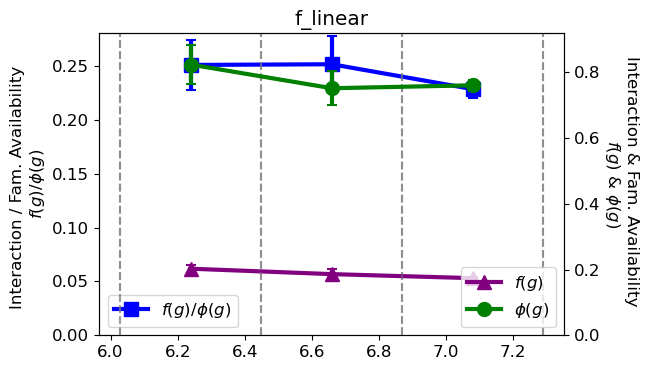

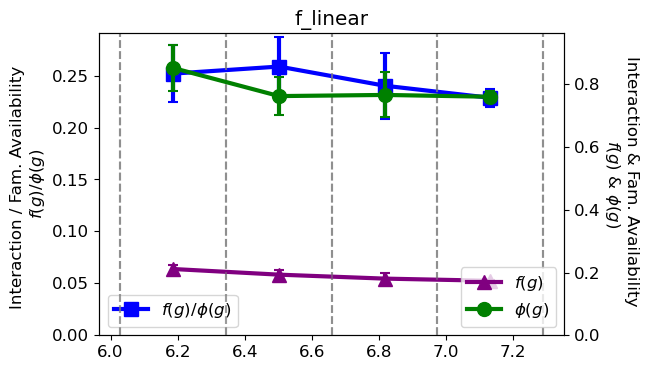

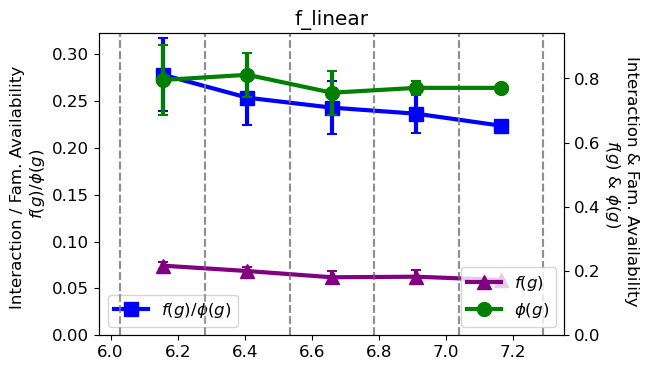

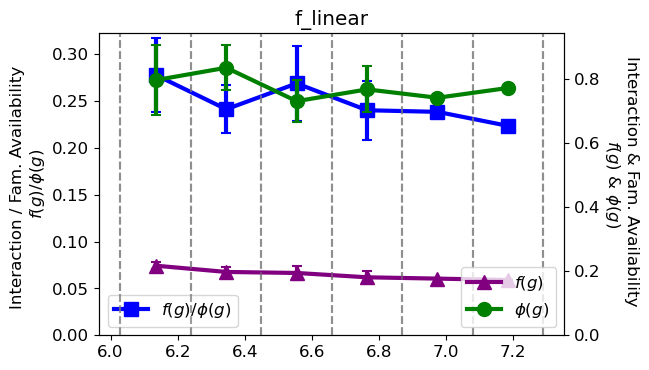

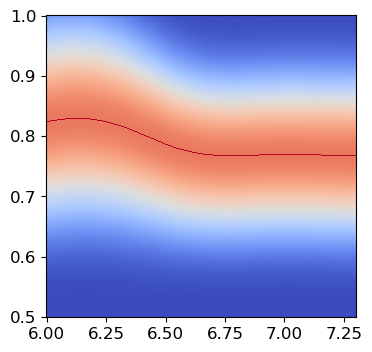

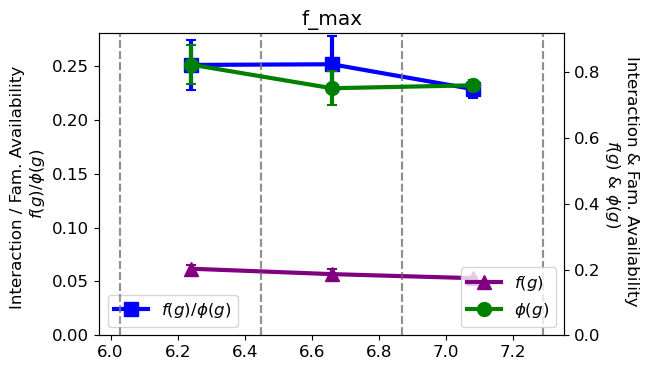

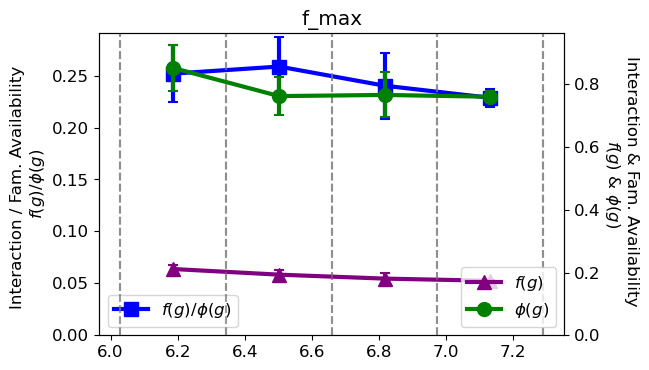

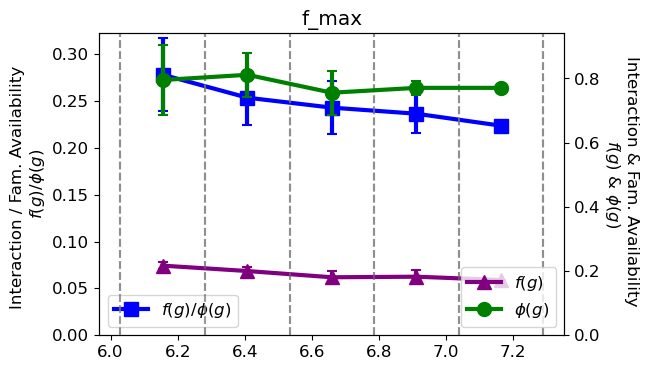

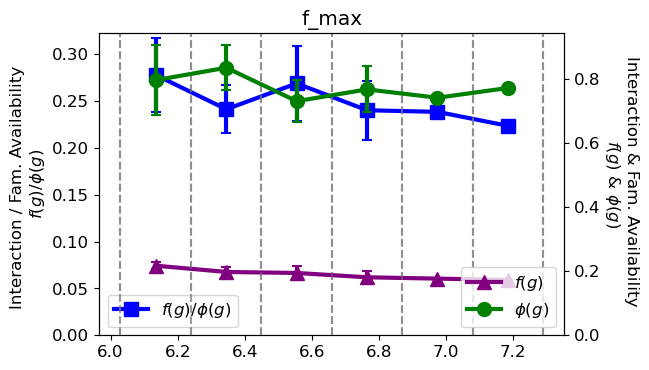

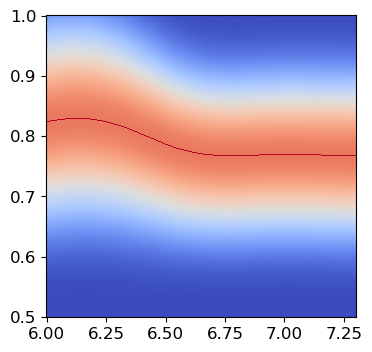

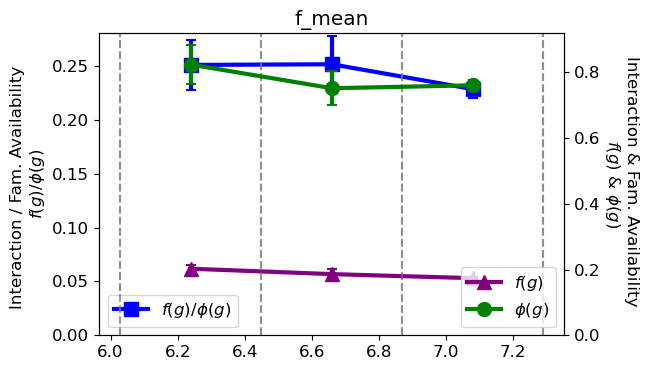

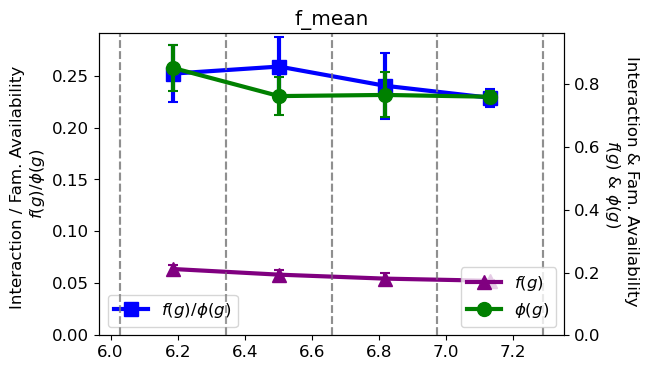

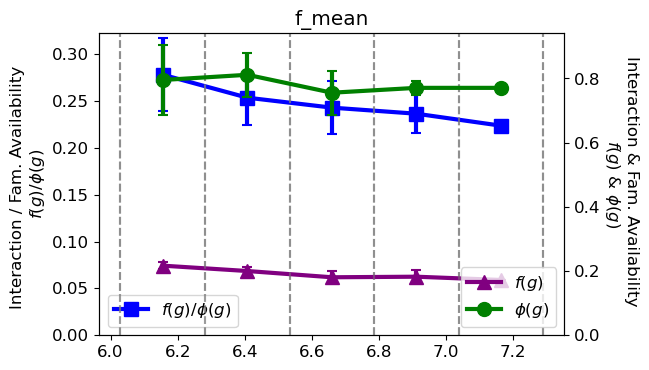

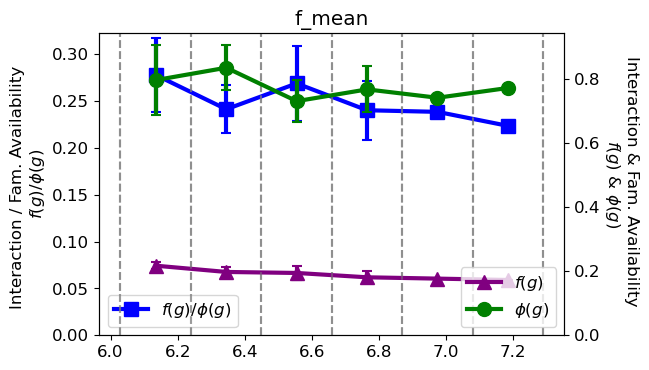

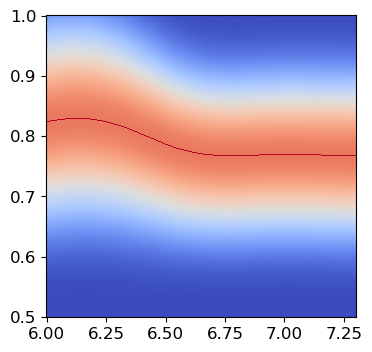

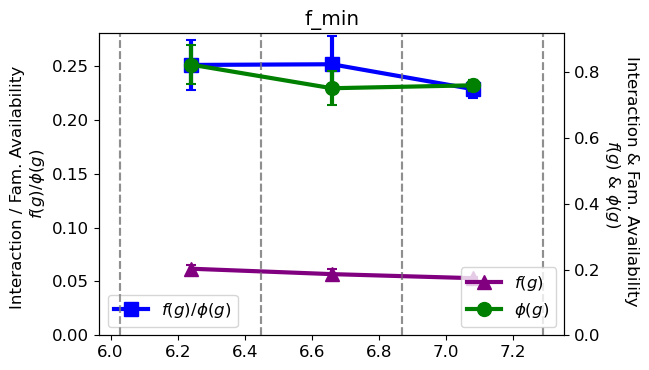

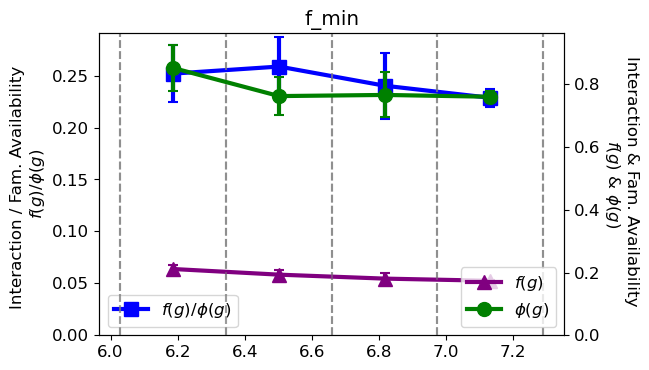

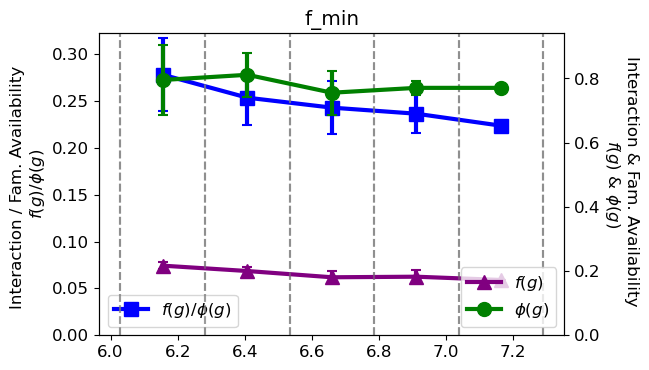

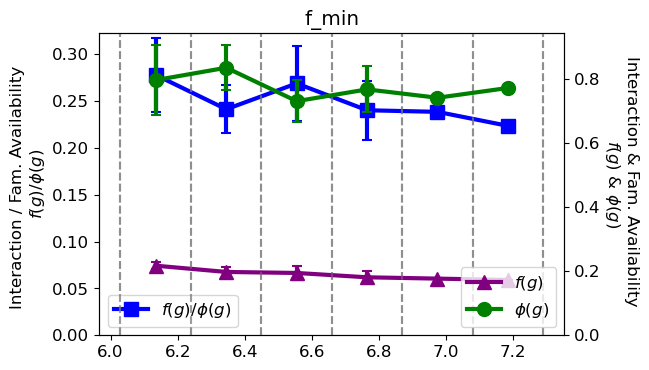

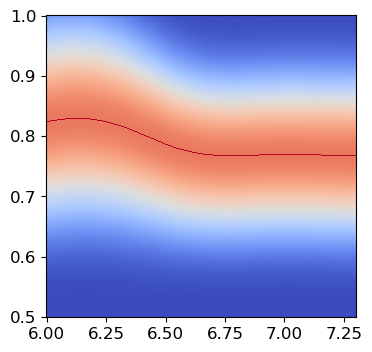

In [658]:
og_n_bins = n_bins
f_vals = [f_linear, f_max, f_mean, f_min]
f_strs = ['f_linear', 'f_max', 'f_mean', 'f_min']

phi_string = 'phi_o'
for idx, fv in enumerate(f_vals):
    for i in range(3,7):
        n_bins = i
        alpha = 'ALL_TU_H'
        f_g = df_tus_trunc.copy()
        f_g = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='inner', on='GTCBSA')
        f_g['pop_bin'] = pd.cut(f_g['LOG_POP'], n_bins,)

        cbsa_popbin = f_g[['GTCBSA','pop_bin']].copy().drop_duplicates()

        # phi_p = df_pew_trunc[['GTCBSA', 'q7_family_members', 'weight']].copy()
        # phi_p = f_g[['GTCBSA','pop_bin']].merge(phi_p, how='left', on='GTCBSA')
        # phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: fv[x] if x==x else 0)
        # phi_p['fam_w'] = phi_p['q7_family_members'] * phi_p['weight']
        # phi_p['GTCBSA'] = phi_p['GTCBSA'].astype(int)
        # phi_p = phi_p.groupby('pop_bin').sum().reset_index()
        # phi_p['phi_p'] = phi_p['fam_w'] / phi_p['weight']
        # phi_p = phi_p[['pop_bin','phi_p']]

        phi_p = df_pew_trunc[['GTCBSA', 'q7_family_members', 'weight']].copy()
        phi_p = f_g[['GTCBSA','pop_bin']].merge(phi_p, how='left', on='GTCBSA')
        phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: fv[x] if x==x else 0)

        if phi_string != 'phi_w':
            phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: 1 if x>0 else 0)

        phi_p['fam_w'] = phi_p['q7_family_members'] * phi_p['weight']
        phi_p['GTCBSA'] = phi_p['GTCBSA'].astype(int)
        phi_p = phi_p.groupby('GTCBSA').sum().reset_index()
        phi_p['phi_p'] = phi_p['fam_w'] / phi_p['weight']
        phi_p = phi_p[['GTCBSA','phi_p']]


        f_p = f_g[['pop_bin',alpha, 'LONGEST_TRIP_DUR']].copy()
        f_p = f_p.groupby('pop_bin').mean().reset_index()
        f_p = f_p[['pop_bin', alpha]]
        f_p.columns = ['pop_bin', 'v']

        f_g = f_g.merge(f_p, on='pop_bin',how='left')
        f_g['within_ell'] = f_g['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
        f_g['incoming_trav'] = f_g.apply(lambda x: x['v'] if np.isnan(x['LONGEST_TRIP_DUR']) else 0, axis=1)
        f_g['alpha_v'] = f_g[alpha] * (f_g['within_ell']+f_g['incoming_trav'])


        f_g = f_g[['TUCASEID','NEW_WEIGHT','GTCBSA',alpha, 'alpha_v']]
        f_g[alpha] = f_g['alpha_v']*f_g['NEW_WEIGHT']
        f_g = f_g.groupby('GTCBSA').sum().reset_index()
        f_g[alpha] = f_g[alpha]/f_g['NEW_WEIGHT']
        f_g = f_g[['GTCBSA',alpha]]

        fg_phig = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='right', on='GTCBSA')
        fg_phig = fg_phig.merge(cbsa_popbin, how='left', on='GTCBSA')
        
        
        #fg_phig = fg_phig.merge(phi_p, how='left', on='pop_bin')
        fg_phig = fg_phig.merge(phi_p, how='left', on='GTCBSA')
        
        
        fg_phig.columns = ['GTCBSA','log(p)', 'f(g)', 'pop_bin', 'phi_p']
        #display(fg_phig)
        fg_phig['f(g)/phi_p'] = fg_phig['f(g)']/fg_phig['phi_p']

        fg_phig = fg_phig.replace(np.inf, 0)

        fig, ax = plt.subplots(figsize=(6,4), dpi=100)
        if phi_string != 'phi_w':
            ax = binplot_dim(ax, fg_phig['log(p)'], fg_phig['f(g)/phi_p'] , n_bins, c=colors[0], l=3, lms=10, s=50, label='$f(g)/\phi(g)$', m='s', alpha=1)
            ax.set_ylabel('Interaction / Fam. Availability \n$f(g) / \phi(g)$')
            ax.set_ylim(0,)
            ax2 = ax.twinx()
            ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['f(g)'] , n_bins, c=colors[2], l=3, lms=10, s=50, label='$f(g)$', linestyle='-', m='^', alpha=1)
            ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['phi_p'] , n_bins, c=colors[1], l=3, lms=10 ,s=50, label='$\phi(g)$', linestyle='-', m="o", alpha=1)
            ax2.set_ylabel('Interaction & Fam. Availability \n$f(g)$ & $\phi(g)$', rotation=270, labelpad=28)
        else:
            ax = binplot_dim(ax, fg_phig['log(p)'], fg_phig['f(g)/phi_p'] , n_bins, c=colors[0], l=3, lms=10, s=50, label='$f(g)/\phi_w(g)$', m='s', alpha=1)
            ax.set_ylabel('Interaction / Fam. Availability \n$f(g) / \phi_w(g)$')
            ax.set_ylim(0,)
            ax2 = ax.twinx()
            ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['f(g)'] , n_bins, c=colors[2], l=3, lms=10, s=50, label='$f(g)$', linestyle='-', m='^', alpha=1)
            ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['phi_p'] , n_bins, c=colors[1], l=3, lms=10 ,s=50, label='$\phi_w(g)$', linestyle='-', m="o", alpha=1)
            ax2.set_ylabel('Interaction & Fam. Availability \n$f(g)$ & $\phi_w(g)$', rotation=270, labelpad=28)
        ax2.set_ylim(0,)
        #fig.legend(loc = 'center', bbox_to_anchor=(0.5,0.2), bbox_transform=ax.transAxes)
        ax.legend(loc='lower left')
        ax2.legend(loc='lower right')
        plt.title(f_strs[idx])
        #plt.tight_layout()
        plt.show()

    from sklearn.neighbors import KernelDensity
    alpha = 'phi_p'
    temp_df = copy.deepcopy(fg_phig)
    temp_df = temp_df[temp_df[alpha] > 0]
    temp_df = temp_df[['log(p)',alpha]]
    x_dim = temp_df['log(p)'].tolist()
    y_dim = temp_df[alpha].tolist()
    X, Y, Z = kde_2d(x_dim, y_dim, bwidth=0.2)
    Z = normalize_whole_plot(Z)
    Z_df = normalize_cols(Z)
    Z_norm = Z_df.to_numpy()
    Z_edit = Z_df.replace(1,1.05).to_numpy()
    fig, axes = plt.subplots(1,1,figsize=(4,4), dpi=100)
    axes.pcolormesh(X,Y,Z_edit**4,cmap='coolwarm',shading='auto')
    plt.show()
    
n_bins = og_n_bins

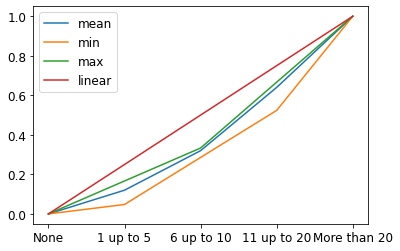

In [628]:
plt.plot(f_mean.keys(), f_mean.values(), label='mean')
plt.plot(f_min.keys(), f_min.values(), label='min')
plt.plot(f_max.keys(), f_max.values(), label='max')
plt.plot(f_linear.keys(), f_linear.values(), label='linear')
plt.legend()

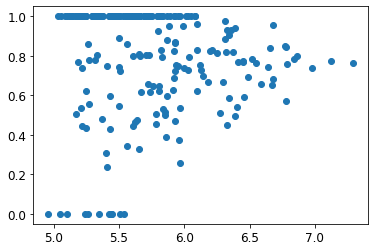

In [629]:
plt.scatter(fg_phig['log(p)'], fg_phig['phi_p'])

In [630]:
n_bins = 6

In [663]:
# og_n_bins = n_bins

# pew_threshold = 10 # will give results > this number

# phi_string = 'phi_o'

# for q in range(0,15):
#     pew_threshold = q
#     print(pew_threshold)

#     df_u_gca_weight = df_resp_weight.merge(df_u_gca, on='TUCASEID', how='left')
#     df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(df_pew['GTCBSA'].tolist())].copy()
#     pew_thr_df = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())].copy()
#     pew_thr_df = pew_thr_df[['GTCBSA']]
#     pew_thr_df['count'] = 1
#     pew_thr_df = pew_thr_df.groupby('GTCBSA').sum()
#     pew_thr_df = pew_thr_df.reset_index()
#     pew_thr_df = pew_thr_df[pew_thr_df['count'] > pew_threshold]
#     df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(pew_thr_df['GTCBSA'].tolist())].copy()
#     df_pew_trunc = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())].copy()

#     print(len(df_pew_trunc['GTCBSA'].unique()))

#     f_min = {'None':0, '1 up to 5':1, '6 up to 10':6, '11 up to 20':11, 'More than 20':21}
#     f_max = {'None':0, '1 up to 5':5, '6 up to 10':10, '11 up to 20':20, 'More than 20':30}
#     f_mean = {'None':0, '1 up to 5':3, '6 up to 10':8, '11 up to 20':16, 'More than 20':25}

#     f_mean_max = max(f_mean.values())
#     for k,v in f_mean.items():
#         f_mean[k] = v/f_mean_max

#     f_min_max = max(f_min.values())
#     for k,v in f_min.items():
#         f_min[k] = v/f_min_max

#     f_max_max = max(f_max.values())
#     for k,v in f_max.items():
#         f_max[k] = v/f_max_max

#     f_linear = {'None':0, '1 up to 5':0.25, '6 up to 10':0.5, '11 up to 20':0.75, 'More than 20':1}


#     og_n_bins = n_bins
#     f_vals = [f_linear, f_max, f_mean, f_min]
#     f_strs = ['f_linear', 'f_max', 'f_mean', 'f_min']


#     for idx, fv in enumerate(f_vals[2:3]):
#         for i in range(2,9):
#             n_bins = i
#             alpha = 'ALL_TU_H'
#             f_g = df_tus_trunc.copy()
#             f_g = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='inner', on='GTCBSA')
#             f_g['pop_bin'] = pd.cut(f_g['LOG_POP'], n_bins,)

#             cbsa_popbin = f_g[['GTCBSA','pop_bin']].copy().drop_duplicates()

#             # phi_p = df_pew_trunc[['GTCBSA', 'q7_family_members', 'weight']].copy()
#             # phi_p = f_g[['GTCBSA','pop_bin']].merge(phi_p, how='left', on='GTCBSA')
#             # phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: fv[x] if x==x else 0)
#             # phi_p['fam_w'] = phi_p['q7_family_members'] * phi_p['weight']
#             # phi_p['GTCBSA'] = phi_p['GTCBSA'].astype(int)
#             # phi_p = phi_p.groupby('pop_bin').sum().reset_index()
#             # phi_p['phi_p'] = phi_p['fam_w'] / phi_p['weight']
#             # phi_p = phi_p[['pop_bin','phi_p']]

#             phi_p = df_pew_trunc[['GTCBSA', 'q7_family_members', 'weight']].copy()
#             phi_p = f_g[['GTCBSA','pop_bin']].merge(phi_p, how='left', on='GTCBSA')
#             phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: fv[x] if x==x else 0)

#             # the following line turns phi_w into phi_0
#             if phi_string != 'phi_w':
#                 phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: 1 if x>0 else 0)

#             phi_p['fam_w'] = phi_p['q7_family_members'] * phi_p['weight']
#             phi_p['GTCBSA'] = phi_p['GTCBSA'].astype(int)
#             phi_p = phi_p.groupby('GTCBSA').sum().reset_index()
#             phi_p['phi_p'] = phi_p['fam_w'] / phi_p['weight']
#             phi_p = phi_p[['GTCBSA','phi_p']]


#             f_p = f_g[['pop_bin',alpha, 'LONGEST_TRIP_DUR']].copy()
#             f_p = f_p.groupby('pop_bin').mean().reset_index()
#             f_p = f_p[['pop_bin', alpha]]
#             f_p.columns = ['pop_bin', 'v']

#             f_g = f_g.merge(f_p, on='pop_bin',how='left')
#             f_g['within_ell'] = f_g['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
#             f_g['incoming_trav'] = f_g.apply(lambda x: x['v'] if np.isnan(x['LONGEST_TRIP_DUR']) else 0, axis=1)
#             f_g['alpha_v'] = f_g[alpha] * (f_g['within_ell']+f_g['incoming_trav'])


#             f_g = f_g[['TUCASEID','NEW_WEIGHT','GTCBSA',alpha, 'alpha_v']]
#             f_g[alpha] = f_g['alpha_v']*f_g['NEW_WEIGHT']
#             f_g = f_g.groupby('GTCBSA').sum().reset_index()
#             f_g[alpha] = f_g[alpha]/f_g['NEW_WEIGHT']
#             f_g = f_g[['GTCBSA',alpha]]

#             fg_phig = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='right', on='GTCBSA')
#             fg_phig = fg_phig.merge(cbsa_popbin, how='left', on='GTCBSA')
            
            
#             #fg_phig = fg_phig.merge(phi_p, how='left', on='pop_bin')
#             fg_phig = fg_phig.merge(phi_p, how='left', on='GTCBSA')
            
            
#             fg_phig.columns = ['GTCBSA','log(p)', 'f(g)', 'pop_bin', 'phi_p']
#             #display(fg_phig)
#             fg_phig['f(g)/phi_p'] = fg_phig['f(g)']/fg_phig['phi_p']

#             fg_phig = fg_phig.replace(np.inf, 0)

#             fig, ax = plt.subplots(figsize=(6,4), dpi=100)

#             if phi_string != 'phi_w':
#                 ax = binplot_dim(ax, fg_phig['log(p)'], fg_phig['f(g)/phi_p'] , n_bins, c=colors[0], l=3, lms=10, s=50, label='$f(g)/\phi(g)$', m='s', alpha=1)
#                 ax.set_ylabel('Interaction / Fam. Availability \n$f(g) / \phi(g)$')
#                 ax.set_ylim(0,)
#                 ax2 = ax.twinx()
#                 ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['f(g)'] , n_bins, c=colors[2], l=3, lms=10, s=50, label='$f(g)$', linestyle='-', m='^', alpha=1)
#                 ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['phi_p'] , n_bins, c=colors[1], l=3, lms=10 ,s=50, label='$\phi(g)$', linestyle='-', m="o", alpha=1)
#                 ax2.set_ylabel('Interaction & Fam. Availability \n$f(g)$ & $\phi(g)$', rotation=270, labelpad=28)
#             else:
#                 ax = binplot_dim(ax, fg_phig['log(p)'], fg_phig['f(g)/phi_p'] , n_bins, c=colors[0], l=3, lms=10, s=50, label='$f(g)/\phi_w(g)$', m='s', alpha=1)
#                 ax.set_ylabel('Interaction / Fam. Availability \n$f(g) / \phi_w(g)$')
#                 ax.set_ylim(0,)
#                 ax2 = ax.twinx()
#                 ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['f(g)'] , n_bins, c=colors[2], l=3, lms=10, s=50, label='$f(g)$', linestyle='-', m='^', alpha=1)
#                 ax2 = binplot_dim(ax2, fg_phig['log(p)'], fg_phig['phi_p'] , n_bins, c=colors[1], l=3, lms=10 ,s=50, label='$\phi_w(g)$', linestyle='-', m="o", alpha=1)
#                 ax2.set_ylabel('Interaction & Fam. Availability \n$f(g)$ & $\phi_w(g)$', rotation=270, labelpad=28)
#             ax2.set_ylim(0,)
#             #fig.legend(loc = 'center', bbox_to_anchor=(0.5,0.2), bbox_transform=ax.transAxes)
#             ax.legend(loc='lower left')
#             ax2.legend(loc='lower right')
#             plt.title(f_strs[idx])
#             #plt.tight_layout()
#             plt.show()

#         from sklearn.neighbors import KernelDensity
#         alpha = 'phi_p'
#         temp_df = copy.deepcopy(fg_phig)
#         temp_df = temp_df[temp_df[alpha] > 0]
#         temp_df = temp_df[['log(p)',alpha]]
#         x_dim = temp_df['log(p)'].tolist()
#         y_dim = temp_df[alpha].tolist()
#         X, Y, Z = kde_2d(x_dim, y_dim, bwidth=0.3)
#         Z = normalize_whole_plot(Z)
#         Z_df = normalize_cols(Z)
#         Z_norm = Z_df.to_numpy()
#         Z_edit = Z_df.replace(1,1.05).to_numpy()
#         fig, axes = plt.subplots(1,1,figsize=(4,4), dpi=100)
#         axes.pcolormesh(X,Y,Z_edit**4,cmap='coolwarm',shading='auto')
#         plt.show()
    
# n_bins = og_n_bins

min_surveyed: 1
retained CBSAs: 226


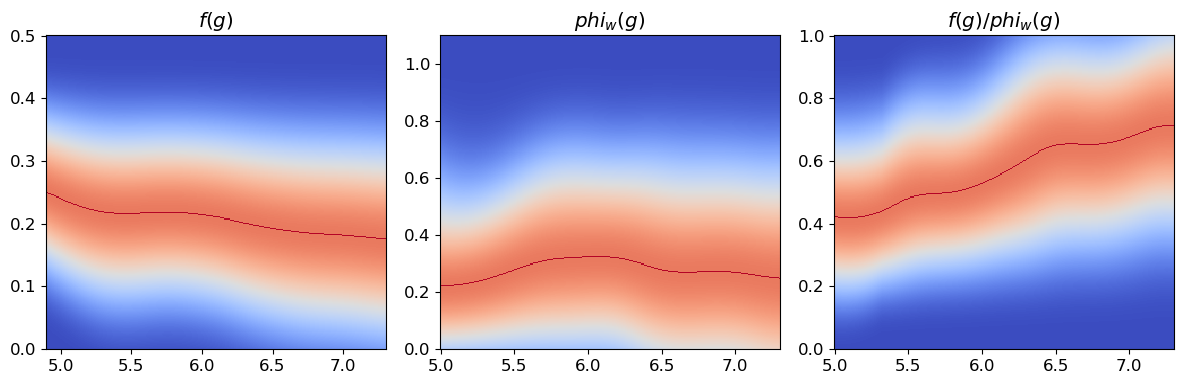

min_surveyed: 2
retained CBSAs: 185


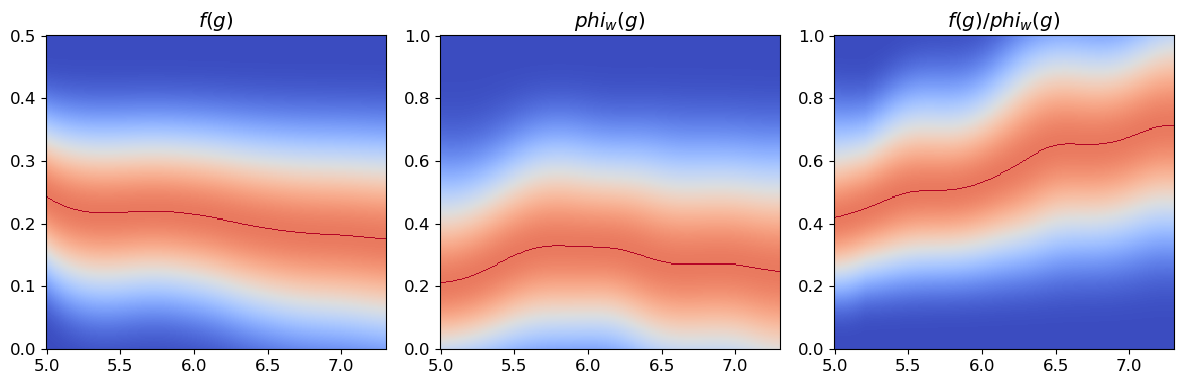

min_surveyed: 3
retained CBSAs: 145


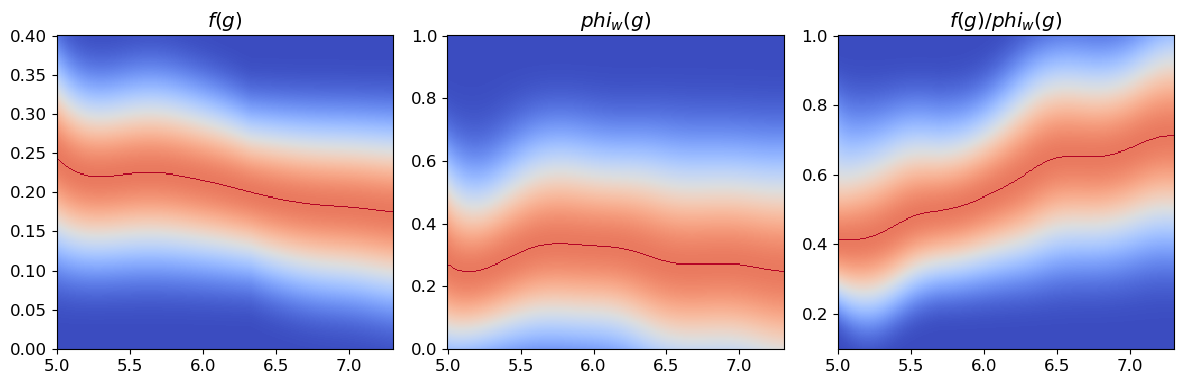

min_surveyed: 4
retained CBSAs: 119


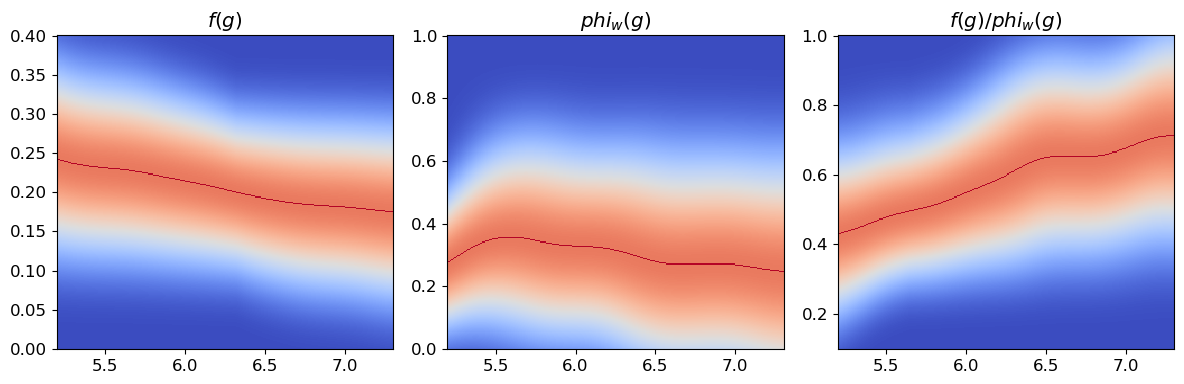

min_surveyed: 5
retained CBSAs: 90


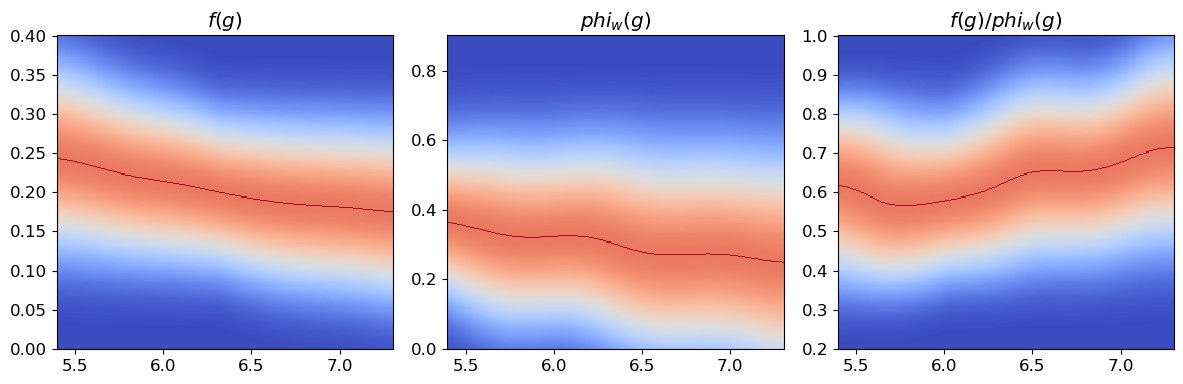

min_surveyed: 6
retained CBSAs: 75


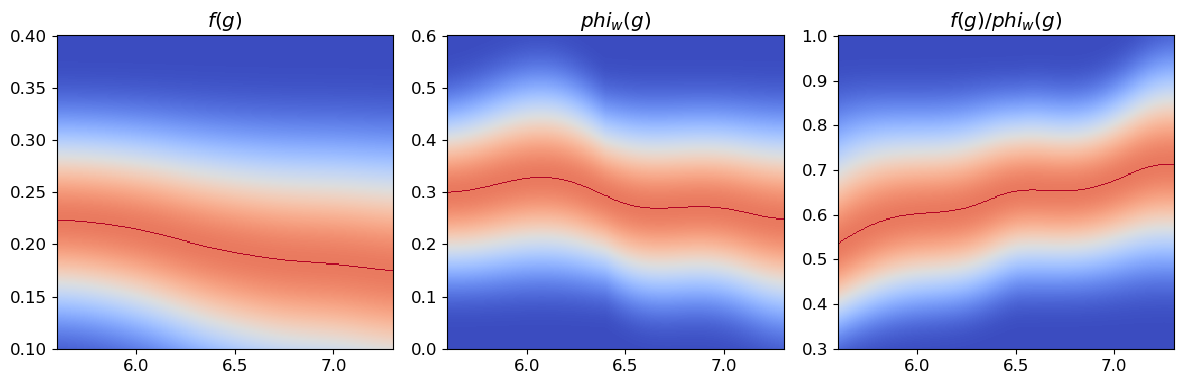

min_surveyed: 7
retained CBSAs: 65


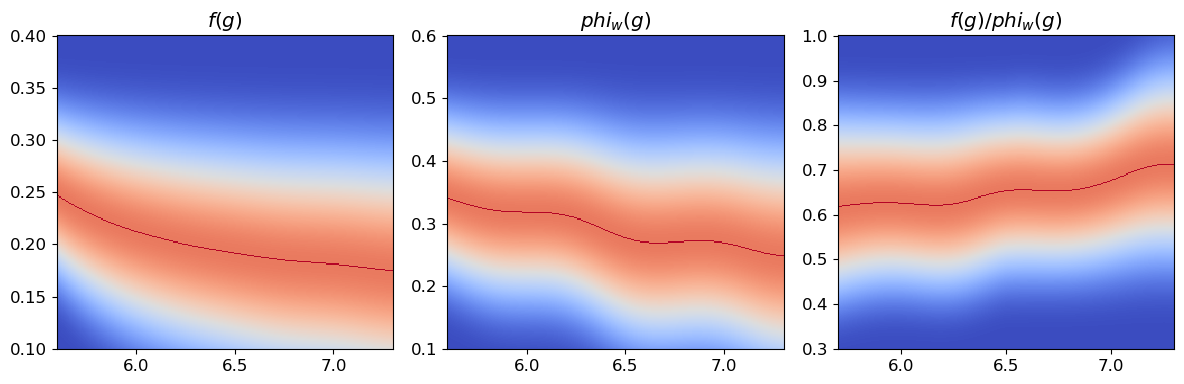

min_surveyed: 8
retained CBSAs: 57


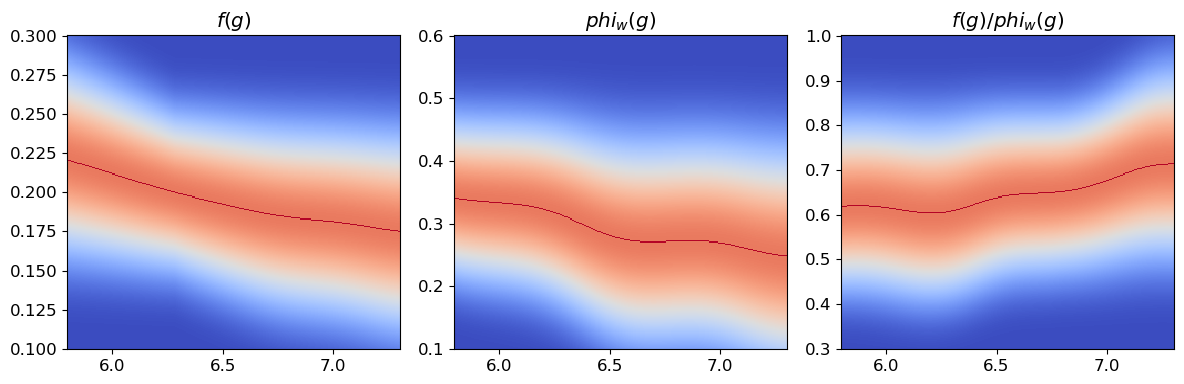

min_surveyed: 9
retained CBSAs: 52


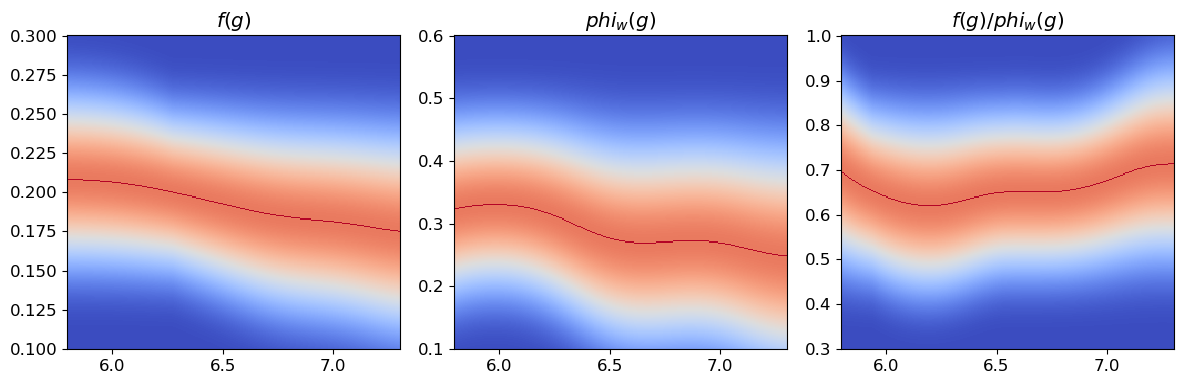

min_surveyed: 10
retained CBSAs: 46


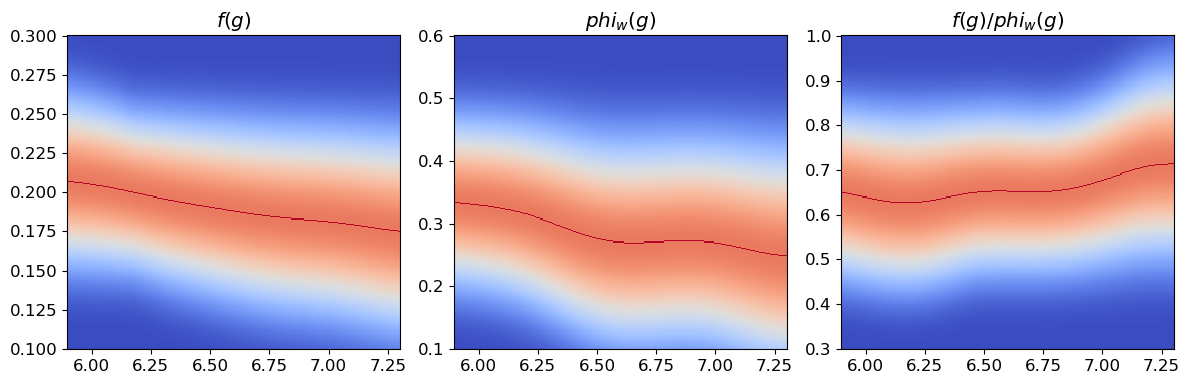

min_surveyed: 11
retained CBSAs: 45


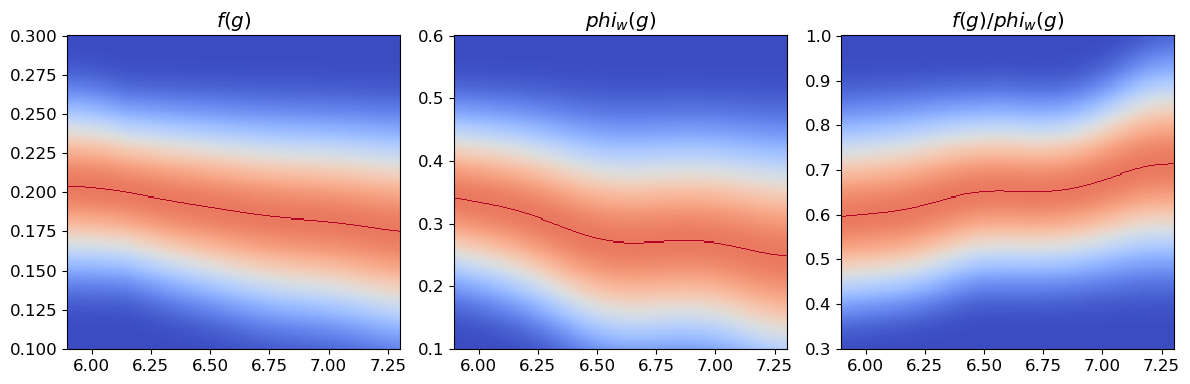

min_surveyed: 12
retained CBSAs: 39


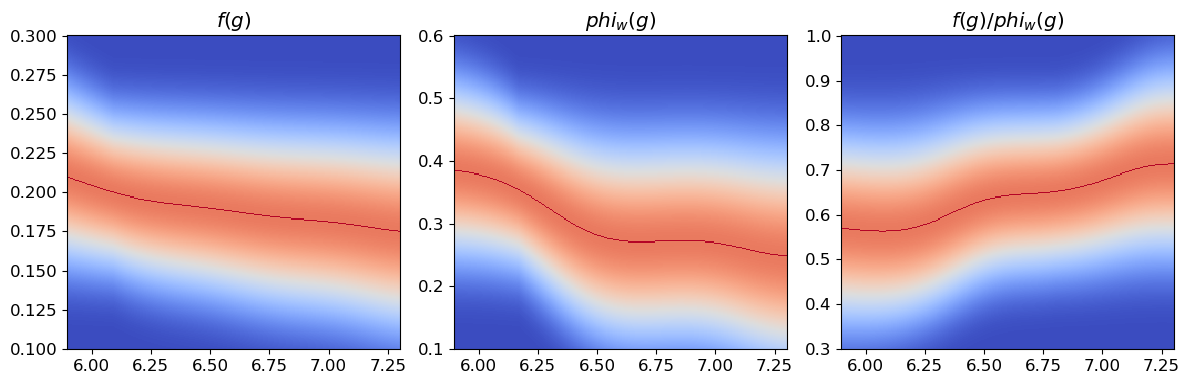

min_surveyed: 13
retained CBSAs: 35


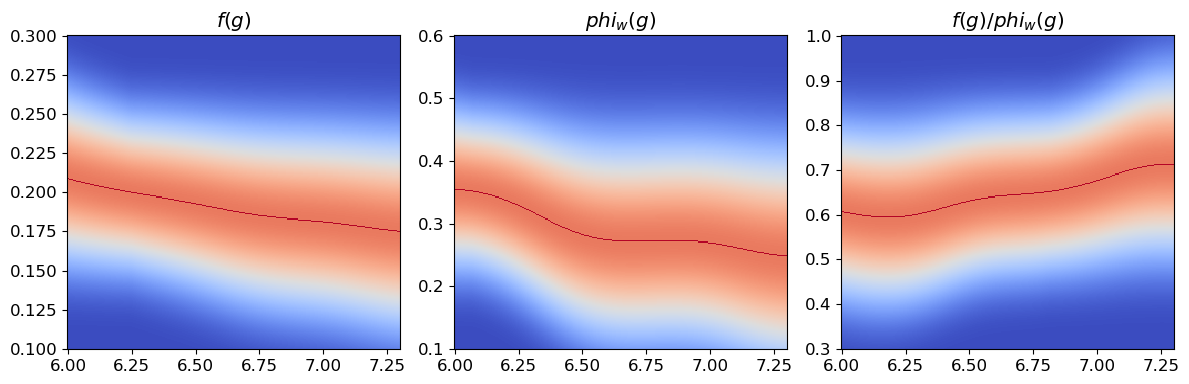

min_surveyed: 14
retained CBSAs: 33


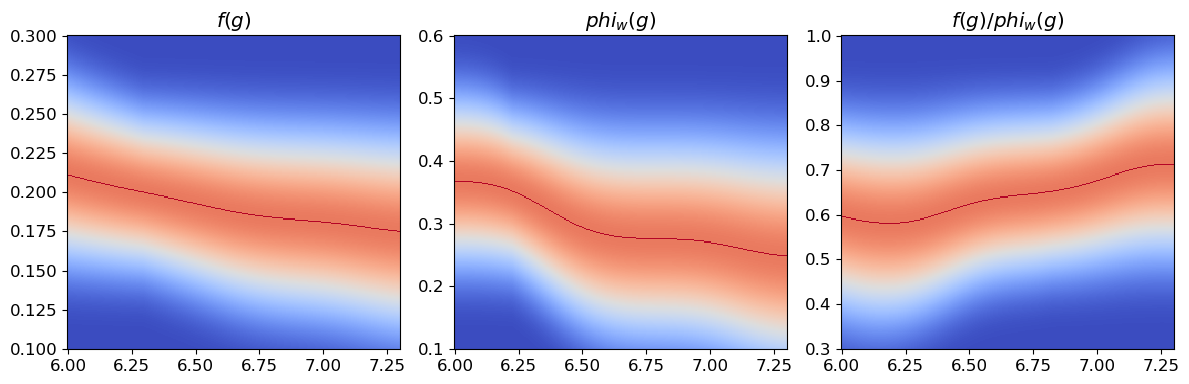

min_surveyed: 15
retained CBSAs: 33


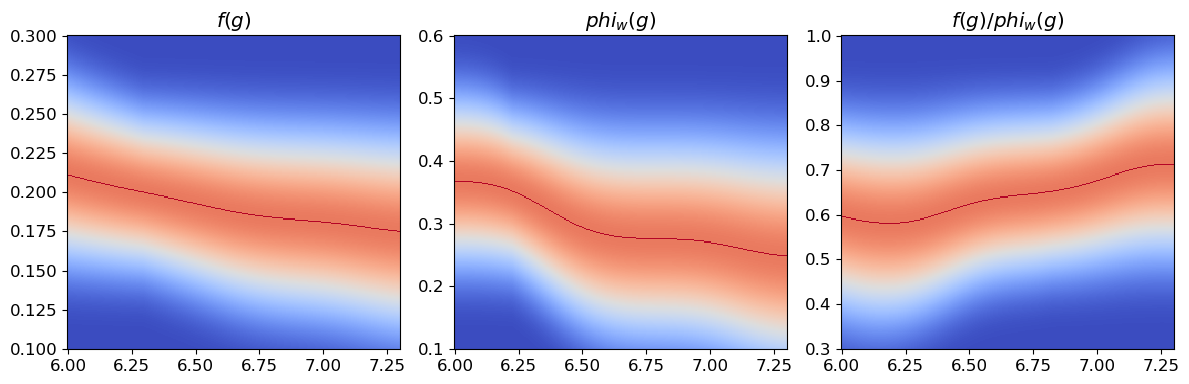

In [680]:
og_n_bins = n_bins

pew_threshold = 10 # will give results > this number

phi_string = 'phi_w'

for q in range(0,15):
    pew_threshold = q
    print('min_surveyed:', pew_threshold+1)

    df_u_gca_weight = df_resp_weight.merge(df_u_gca, on='TUCASEID', how='left')
    df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(df_pew['GTCBSA'].tolist())].copy()
    pew_thr_df = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())].copy()
    pew_thr_df = pew_thr_df[['GTCBSA']]
    pew_thr_df['count'] = 1
    pew_thr_df = pew_thr_df.groupby('GTCBSA').sum()
    pew_thr_df = pew_thr_df.reset_index()
    pew_thr_df = pew_thr_df[pew_thr_df['count'] > pew_threshold]
    df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(pew_thr_df['GTCBSA'].tolist())].copy()
    df_pew_trunc = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())].copy()

    print('retained CBSAs:',len(df_pew_trunc['GTCBSA'].unique()))

    f_min = {'None':0, '1 up to 5':1, '6 up to 10':6, '11 up to 20':11, 'More than 20':21}
    f_max = {'None':0, '1 up to 5':5, '6 up to 10':10, '11 up to 20':20, 'More than 20':30}
    f_mean = {'None':0, '1 up to 5':3, '6 up to 10':8, '11 up to 20':16, 'More than 20':25}

    f_mean_max = max(f_mean.values())
    for k,v in f_mean.items():
        f_mean[k] = v/f_mean_max

    f_min_max = max(f_min.values())
    for k,v in f_min.items():
        f_min[k] = v/f_min_max

    f_max_max = max(f_max.values())
    for k,v in f_max.items():
        f_max[k] = v/f_max_max

    f_linear = {'None':0, '1 up to 5':0.25, '6 up to 10':0.5, '11 up to 20':0.75, 'More than 20':1}


    og_n_bins = n_bins
    f_vals = [f_linear, f_max, f_mean, f_min]
    f_strs = ['f_linear', 'f_max', 'f_mean', 'f_min']


    for idx, fv in enumerate(f_vals[2:3]):
        n_bins = 6
        alpha = 'ALL_TU_H'
        f_g = df_tus_trunc.copy()
        f_g = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='inner', on='GTCBSA')
        f_g['pop_bin'] = pd.cut(f_g['LOG_POP'], n_bins,)

        cbsa_popbin = f_g[['GTCBSA','pop_bin']].copy().drop_duplicates()

        # phi_p = df_pew_trunc[['GTCBSA', 'q7_family_members', 'weight']].copy()
        # phi_p = f_g[['GTCBSA','pop_bin']].merge(phi_p, how='left', on='GTCBSA')
        # phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: fv[x] if x==x else 0)
        # phi_p['fam_w'] = phi_p['q7_family_members'] * phi_p['weight']
        # phi_p['GTCBSA'] = phi_p['GTCBSA'].astype(int)
        # phi_p = phi_p.groupby('pop_bin').sum().reset_index()
        # phi_p['phi_p'] = phi_p['fam_w'] / phi_p['weight']
        # phi_p = phi_p[['pop_bin','phi_p']]

        phi_p = df_pew_trunc[['GTCBSA', 'q7_family_members', 'weight']].copy()
        phi_p = f_g[['GTCBSA','pop_bin']].merge(phi_p, how='left', on='GTCBSA')
        phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: fv[x] if x==x else 0)

        # the following line turns phi_w into phi_0
        if phi_string != 'phi_w':
            phi_p['q7_family_members'] = phi_p['q7_family_members'].apply(lambda x: 1 if x>0 else 0)

        phi_p['fam_w'] = phi_p['q7_family_members'] * phi_p['weight']
        phi_p['GTCBSA'] = phi_p['GTCBSA'].astype(int)
        phi_p = phi_p.groupby('GTCBSA').sum().reset_index()
        phi_p['phi_p'] = phi_p['fam_w'] / phi_p['weight']
        phi_p = phi_p[['GTCBSA','phi_p']]


        f_p = f_g[['pop_bin',alpha, 'LONGEST_TRIP_DUR']].copy()
        f_p = f_p.groupby('pop_bin').mean().reset_index()
        f_p = f_p[['pop_bin', alpha]]
        f_p.columns = ['pop_bin', 'v']

        f_g = f_g.merge(f_p, on='pop_bin',how='left')
        f_g['within_ell'] = f_g['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
        f_g['incoming_trav'] = f_g.apply(lambda x: x['v'] if np.isnan(x['LONGEST_TRIP_DUR']) else 0, axis=1)
        f_g['alpha_v'] = f_g[alpha] * (f_g['within_ell']+f_g['incoming_trav'])


        f_g = f_g[['TUCASEID','NEW_WEIGHT','GTCBSA',alpha, 'alpha_v']]
        f_g[alpha] = f_g['alpha_v']*f_g['NEW_WEIGHT']
        f_g = f_g.groupby('GTCBSA').sum().reset_index()
        f_g[alpha] = f_g[alpha]/f_g['NEW_WEIGHT']
        f_g = f_g[['GTCBSA',alpha]]

        fg_phig = df_cbsa[['GTCBSA','LOG_POP']].merge(f_g, how='right', on='GTCBSA')
        fg_phig = fg_phig.merge(cbsa_popbin, how='left', on='GTCBSA')
        
        
        #fg_phig = fg_phig.merge(phi_p, how='left', on='pop_bin')
        fg_phig = fg_phig.merge(phi_p, how='left', on='GTCBSA')
        
        
        fg_phig.columns = ['GTCBSA','log(p)', 'f(g)', 'pop_bin', 'phi_p']
        #display(fg_phig)
        fg_phig['f(g)/phi_p'] = fg_phig['f(g)']/fg_phig['phi_p']

        fg_phig = fg_phig.replace(np.inf, 0)

        fg_phig['f(g)/phi_p'] = fg_phig['f(g)/phi_p'].apply(lambda x: x if x < 1 else np.nan)

        fig, axes = plt.subplots(1,3,figsize=(12,4), dpi=100)
        if phi_string != 'phi_w':
            strings = ['$f(g)$','$phi(g)$', '$f(g)/phi(g)$']
        else:
            strings = ['$f(g)$','$phi_w(g)$', '$f(g)/phi_w(g)$']
        for idx, var in enumerate(['f(g)','phi_p','f(g)/phi_p']):
            temp_df = copy.deepcopy(fg_phig)
            temp_df = temp_df[temp_df[var] > 0]
            temp_df = temp_df[['log(p)',var]]
            x_dim = temp_df['log(p)'].tolist()
            y_dim = temp_df[var].tolist()
            X, Y, Z = kde_2d(x_dim, y_dim, bwidth=0.2)
            Z = normalize_whole_plot(Z)
            Z_df = normalize_cols(Z)
            Z_norm = Z_df.to_numpy()
            Z_edit = Z_df.replace(1,1.05).to_numpy()
            
            axes[idx].pcolormesh(X,Y,Z_edit**4,cmap='coolwarm',shading='auto')
            axes[idx].set_title(strings[idx])
        plt.tight_layout()
        plt.show()
    
n_bins = og_n_bins

In [678]:
fg_phig

GTCBSA  log(p)      f(g)         pop_bin     phi_p  f(g)/phi_p
0     10420    5.85  0.253643  (5.737, 6.125]  0.159578    1.589459
1     10580    5.94  0.193958  (5.737, 6.125]  0.360620    0.537846
2     10740    5.96  0.221652  (5.737, 6.125]  0.176306    1.257200
3     10900    5.92  0.186122  (5.737, 6.125]  0.366879    0.507312
4     11100    5.42  0.266585  (5.348, 5.737]  0.120000    2.221540
..      ...     ...       ...             ...       ...         ...
221   49180    5.82  0.325480  (5.737, 6.125]  0.650328    0.500486
222   49340    5.97  0.177878  (5.737, 6.125]  0.714483    0.248961
223   49620    5.65  0.236009  (5.348, 5.737]  0.454642    0.519109
224   49660    5.73  0.310505  (5.348, 5.737]  0.673353    0.461132
225   49740    5.32  0.356121  (4.958, 5.348]  0.093333    3.815584

[226 rows x 6 columns]